In [1]:
import numpy as np
%matplotlib notebook
import pylab as plt
import pickle as pickle

import networkx as nx

from NAQ_graphs import NAQ

#for automatic graph generation
import yaml as yaml
from graph_generator import generate_graph
import os as os

In [2]:
#create a small world network, using automatic generation, see generate_graph and graph_params for more

graph_tpe = 'SM'
params = yaml.load(open('graph_params.yaml','rb'))[graph_tpe]

G, pos  = generate_graph(tpe=graph_tpe, params = params)

if not os.path.isdir(graph_tpe):
    os.mkdir(graph_tpe)
os.chdir(graph_tpe)


/home/arnaudon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  after removing the cwd from sys.path.


In [3]:
#setup the main object
chi = np.array([ 1.j for i in range(len(G.edges))])

naq_u1 = NAQ(G, positions = pos, chi = chi, group = 'U1', open_graph = True)

naq_u1.n_processes_scan = 4 #number of CPU to use

#random update
naq_u1.update_chi([1.,1.])

#construct the graph laplacian
naq_u1.update_laplacian()

Total lenght: 8.082452920089256
Average lenght: 0.7347684472808415


In [4]:
#load the modes found in test_NAQ_U1_open.ipynb
modes = pickle.load(open('modes.pkl', 'rb'))
Ks, Alphas, s = pickle.load( open('scan.pkl', 'rb'))

In [5]:
#pump parameters (see SALT papers)
naq_u1.pump_params = {}
naq_u1.pump_params['gamma_perp'] = 2.
naq_u1.pump_params['k_a']        = 10.
naq_u1.pump_params['D0']         = 0 
naq_u1.pump_params['edges']      = np.arange(len(naq_u1.graph.edges))  #edges to pump


In [6]:
def linear_lasing_threshold(self, mode, D0):
            """
            Estimate the lasing threshold using linear approximation, for a mode with pumping D0
            """
                    
            #update the laplacian
            self.pump_params['D0'] = D0
            self.update_chi(mode)
            self.update_laplacian()
            
            
            #compute the node field
            phi = self.compute_solution()
            
            self.Z_matrix_U1() #compute the Z matrix
            edge_norm = self.Winv.dot(self.Z).dot(self.Winv) #compute the correct weight matrix
            
            #compute the inner sum
            L0_in = self.BT.dot(edge_norm.dot(self.in_mask)).dot(self.B).asformat('csc')
            L0_in_norm = phi.T.dot(L0_in.dot(phi))
            
            #compute the field on the pump
            L0_I = self.BT.dot(edge_norm.dot(self.pump_mask.dot(self.in_mask))).dot(self.B).asformat('csc')
            L0_I_norm = phi.T.dot(L0_I.dot(phi))
        
            #overlapping factor
            f = L0_I_norm/L0_in_norm

            #complex wavenumber
            k = mode[0]-1.j*mode[1]
            
            #gamma factor
            gamma = self.pump_params['gamma_perp'] / ( k - self.pump_params['k_a'] + 1.j * self.pump_params['gamma_perp'])
            
            #Q-value
            Q = mode[0]/(2*mode[1])
            #estimated D_th
            D_th = 1./(Q*np.imag(-gamma)*np.real(f))

            return D_th


In [7]:
import scipy as sc

def Dinvs(self, modes):
    """
    for each edge, compute the 1/D_th for each mode in a matrix
    """
    
    D_invs = np.zeros([len(modes),len(self.graph.edges)])
    for m in range(len(modes)): #loop over all modes
        mode = modes[m]
        self.pump_params['edges'] = np.arange(len(naq_u1.graph.edges))  #set all edges to pump
        
        self.update_chi(modes[m])
        self.update_laplacian()
        phi = naq_u1.compute_solution()
        self.Z_matrix_U1() #compute the Z matrix
        
        edge_norm = self.Winv.dot(self.Z).dot(self.Winv) #compute the correct weight matrix
        
        #compute the inner sum
        L0_in = self.BT.dot(edge_norm.dot(self.in_mask)).dot(self.B).asformat('csc')
        L0_in_norm = phi.T.dot(L0_in.dot(phi))
            
        
        for e in range(len(self.graph.edges)): #loop over all edges
            #create the pump mask
            pump_mask = np.zeros(2*len(self.graph.edges)) 
            pump_mask[2*e] = 1  
            pump_mask[2*e+1] = 1  

            #compute the field on the pump
            L0_I = self.BT.dot(edge_norm.dot(sc.sparse.diags(pump_mask).dot(self.in_mask))).dot(self.B).asformat('csc')
            L0_I_norm = phi.T.dot(L0_I.dot(phi))
        
            #overlapping factor
            f = L0_I_norm/L0_in_norm

            #complex wavenumber
            k = mode[0]-1.j*mode[1]
            
            #gamma factor
            gamma = self.pump_params['gamma_perp'] / ( k - self.pump_params['k_a'] + 1.j * self.pump_params['gamma_perp'])
            
            #Q-value
            Q = mode[0]/(2*mode[1])
            #estimated D_th
            D_th = 1./(Q*np.imag(-gamma)*np.real(f))

        

            #compute the lasing threshold and invert it
            D_invs[m,e] = 1./D_th#naq_u1.linear_lasing_threshold(modes[m], 0, fix_laplacian= True)
            
    return D_invs

D_invs = Dinvs(naq_u1, modes)

/home/arnaudon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in double_scalars


<IPython.core.display.Javascript object>


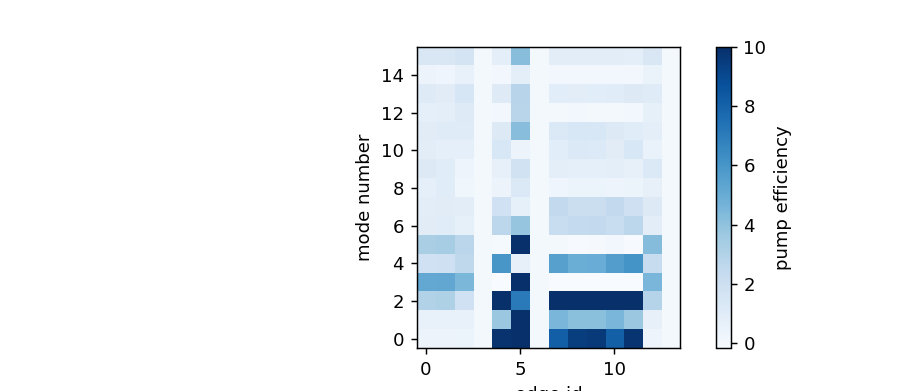

In [26]:
plt.figure(figsize=(7,3))
plt.imshow(D_invs, origin = 'auto', cmap='Blues', vmax = 10)#, vmin= np.min(D_invs), vmax = -np.min(D_invs))

plt.colorbar(label="pump efficiency")
plt.xlabel('edge id')
plt.ylabel('mode number')
plt.savefig('pump_map.svg', bbox_inches='tight')


<IPython.core.display.Javascript object>


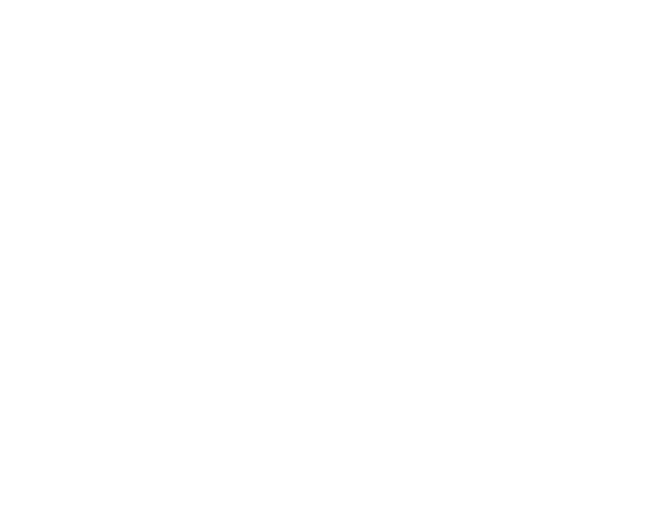

<IPython.core.display.Javascript object>


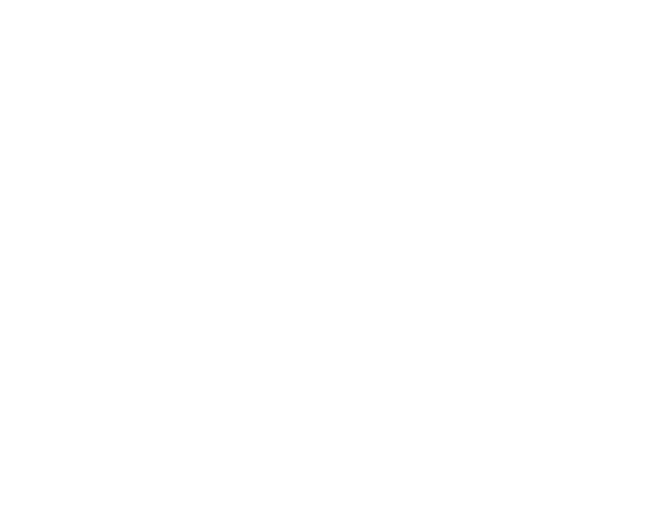

<IPython.core.display.Javascript object>


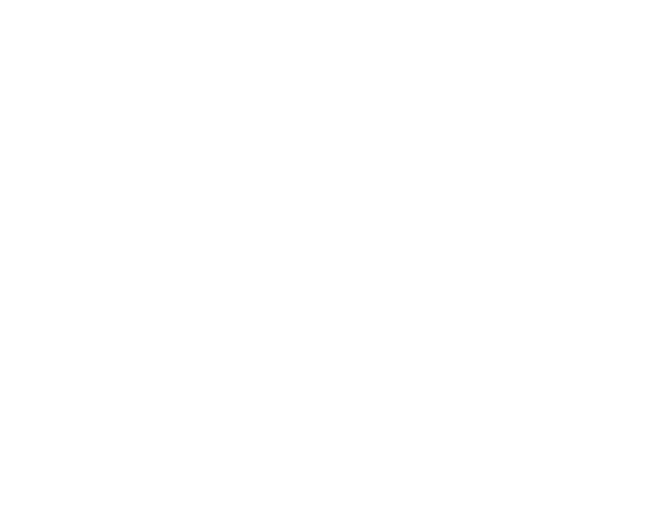

<IPython.core.display.Javascript object>


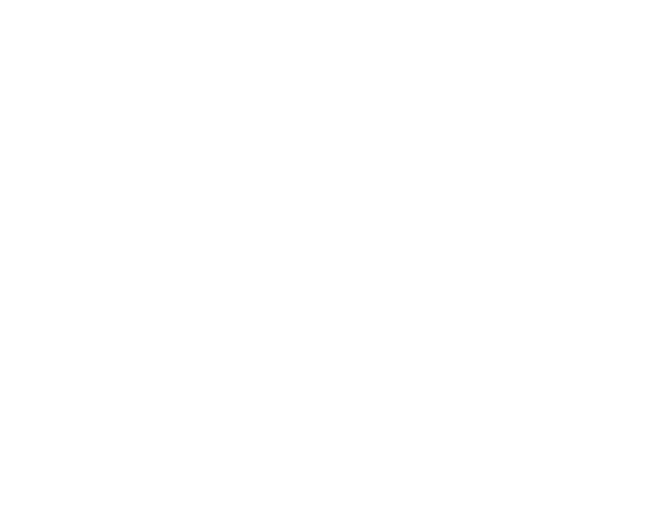

<IPython.core.display.Javascript object>


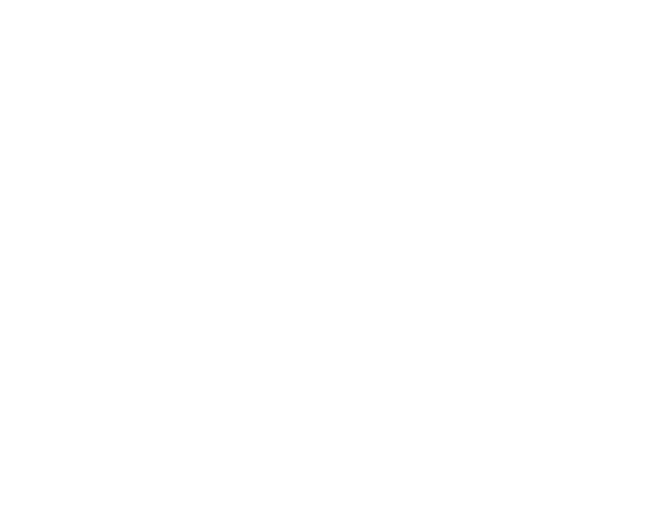

<IPython.core.display.Javascript object>


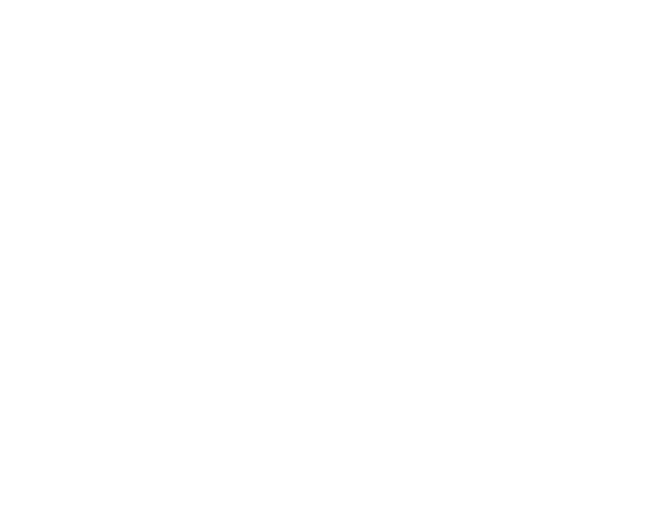

<IPython.core.display.Javascript object>


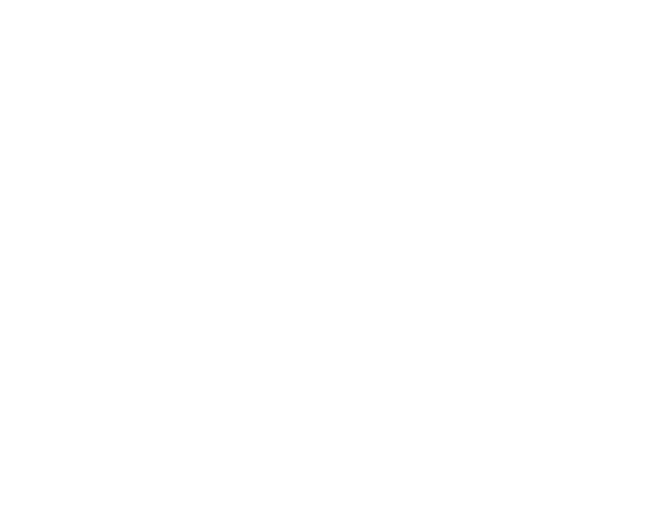

<IPython.core.display.Javascript object>


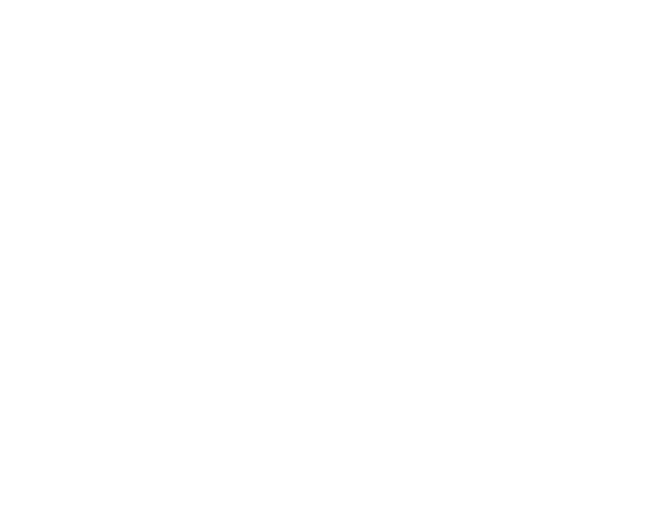

<IPython.core.display.Javascript object>


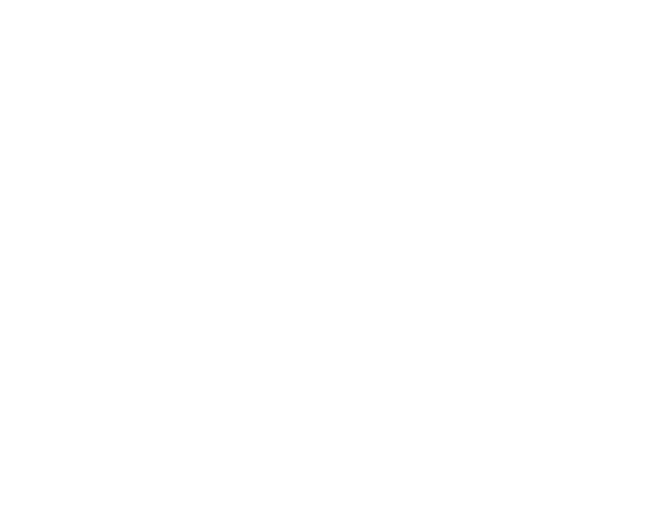

<IPython.core.display.Javascript object>


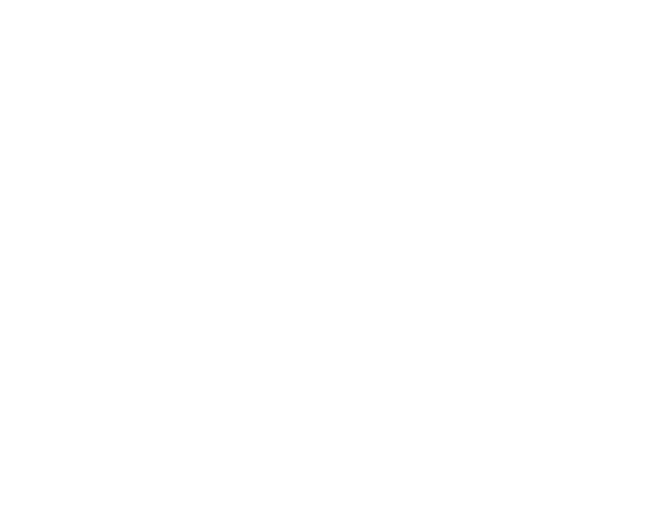

<IPython.core.display.Javascript object>


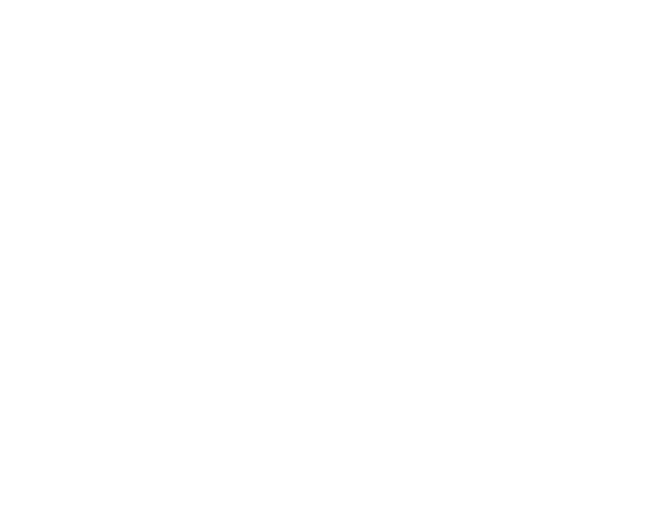

<IPython.core.display.Javascript object>


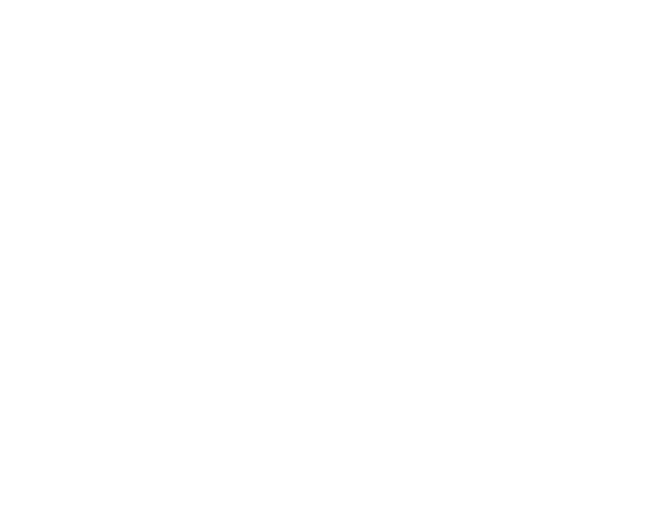

<IPython.core.display.Javascript object>


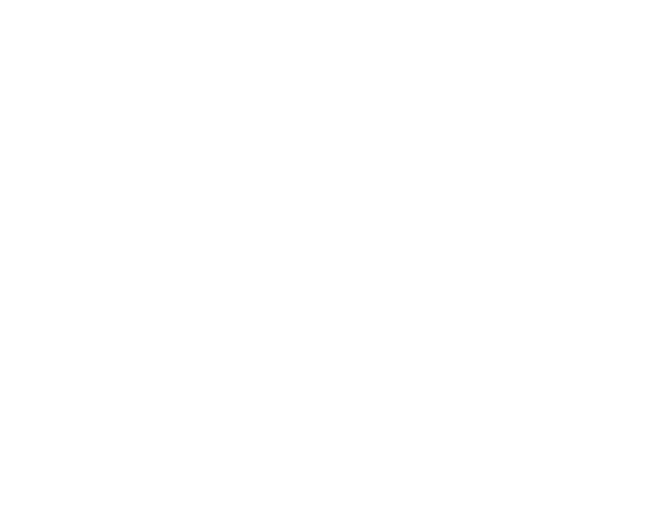

<IPython.core.display.Javascript object>


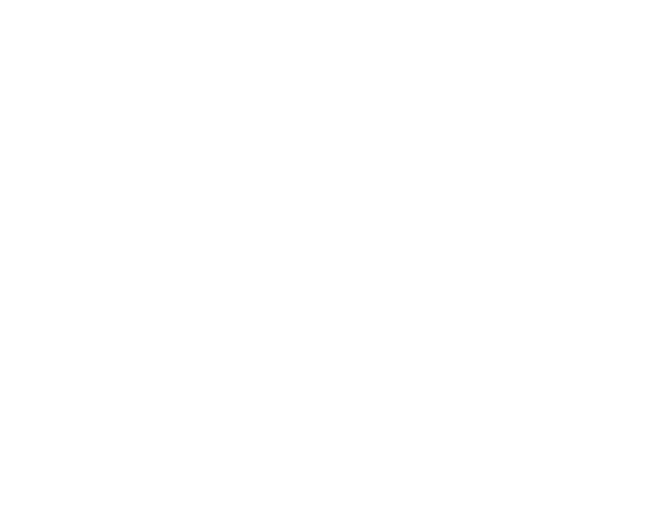

<IPython.core.display.Javascript object>


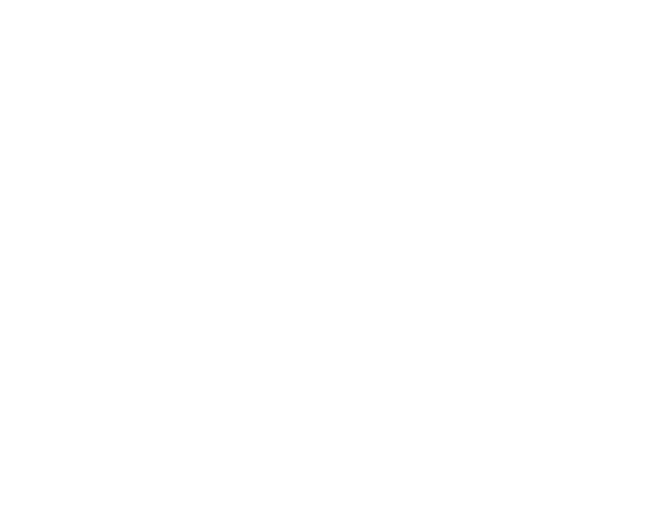

<IPython.core.display.Javascript object>


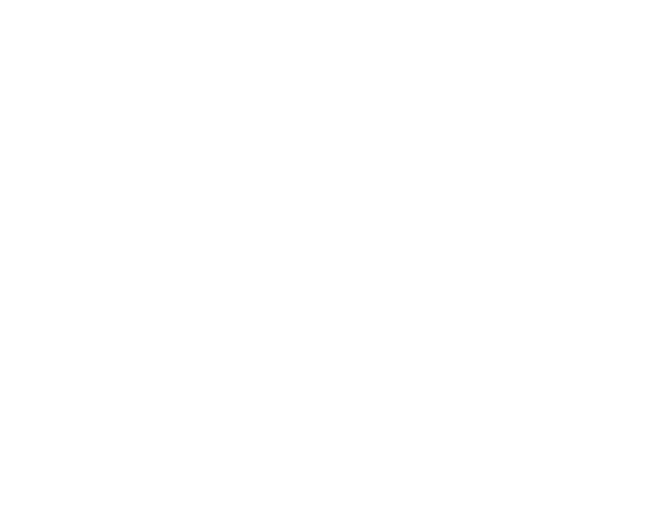

In [9]:

def find_list_edges(self, modes, D_invs, mode_0):
    """
    sort the edges by efficiency for single lasing of mode_0
    """
    
    best_e = []
    for e in range(len(self.graph.edges)):
        if e in self.in_mask_list: #for edges in the inner part
            De = []
            #for all modes except mode_0, store the difference between the efficiency with mode_0
            for m in range(len(modes)): 
                if m is not mode_0:
                    De.append(D_invs[mode_0, e] - D_invs[m, e])
                    
            #only store the smallest difference (if negative, another mode lases before mode_0)
            best_e.append(np.min(De))
            
        else: #for edges not inside, set it low
            best_e.append(-100000)
                
    #return the sorted list of best edges (from best to worst)
    return np.argsort(best_e)[::-1]

def pump_th(self, p_len, modes, D_invs, mode):
        edge_id = find_list_edges(self, modes, D_invs, mode)
        
        D_th = 1./(D_invs[mode, edge_id[:p_len]]).sum()
        
        return D_th

def plot_pumps(self, modes, mode_0, D0):
    """
    plot for each mode, the pump threshold by adding one edge at a time
    """

    #loop over all edges to compute the efficiencies
    for e in range(len(self.graph.edges)-1):
        #count the number of other modes which can lase
        lasing_count = 0
        for m in range(len(modes)):
            if m is not mode_0:
                if pump_th(self, e+1, modes, D_invs, m) < D0:
                    lasing_count += 1
                
        if lasing_count == 0:
            color='r'
        else:
            color='k'

        #if the mode_0 can lase, plot circles
        if pump_th(self, e+1,  modes, D_invs, mode_0) < D0:
            plt.scatter(e+1, pump_th(self, e+1, modes, D_invs, mode_0), marker = 'o', s = 50*(lasing_count+1), c=color)
        
        #otherswise, plot triangles
        else:
            plt.scatter(e+1, pump_th(self, e+1, modes, D_invs, mode_0), marker = '>', s = 50*(lasing_count+1), c=color)


D0 = 0.08
mode_0 = 2
for m in range(len(modes)):
    plt.figure(figsize=(5,4))

    plot_pumps(naq_u1, modes, m, D0)
    plt.axhline(D0)
    plt.title('mode '+str(m))#+', k=' + str(modes[m]))
    plt.xlabel('number of edges in the pump')
    plt.ylabel('lasing threshold')
    plt.savefig('pump_th/mode'+str(m)+'.svg', bbox_inches='tight')
    plt.close()
    

k= (13.451905063481771-0.02239796758229117j)


<IPython.core.display.Javascript object>


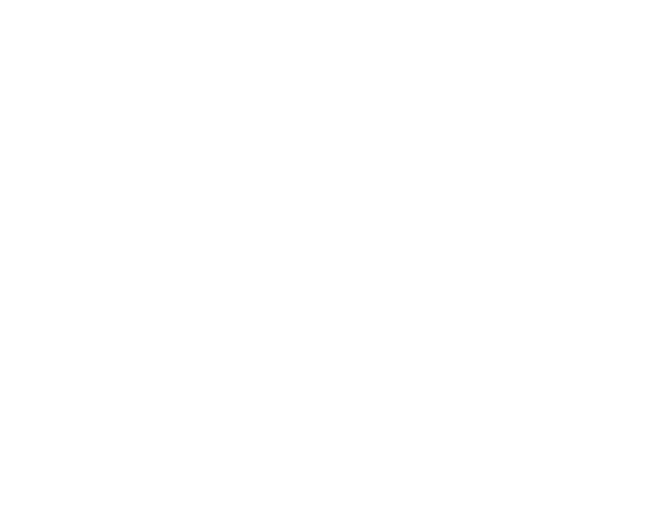

k= (7.820276277261286-0.04784911274148386j)


<IPython.core.display.Javascript object>


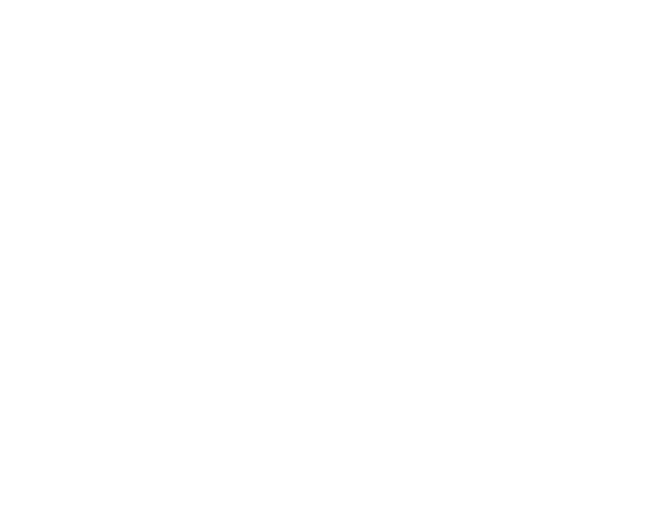

k= (11.126461942891384-0.051728528817423985j)


<IPython.core.display.Javascript object>


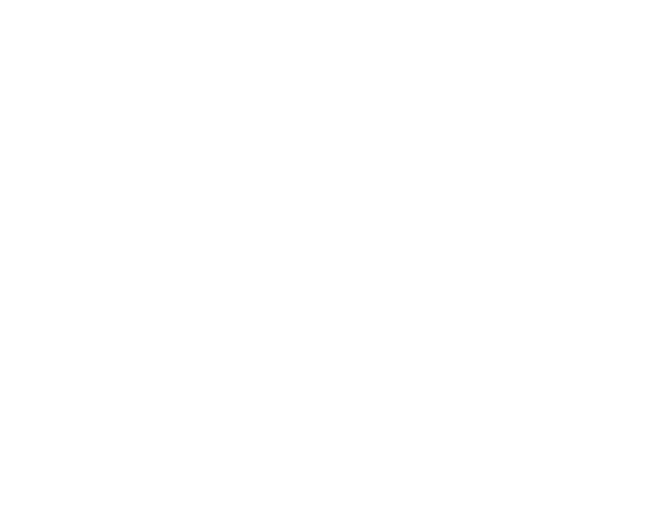

k= (11.489061167293576-0.09479351855554906j)


<IPython.core.display.Javascript object>


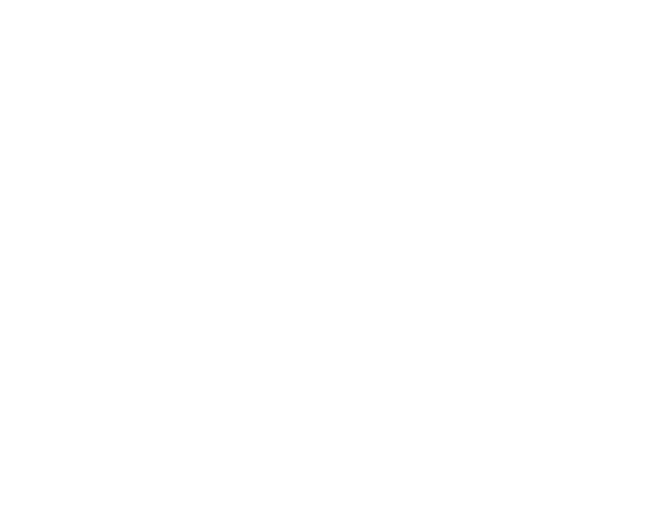

k= (9.183869537794106-0.09589533135307607j)


<IPython.core.display.Javascript object>


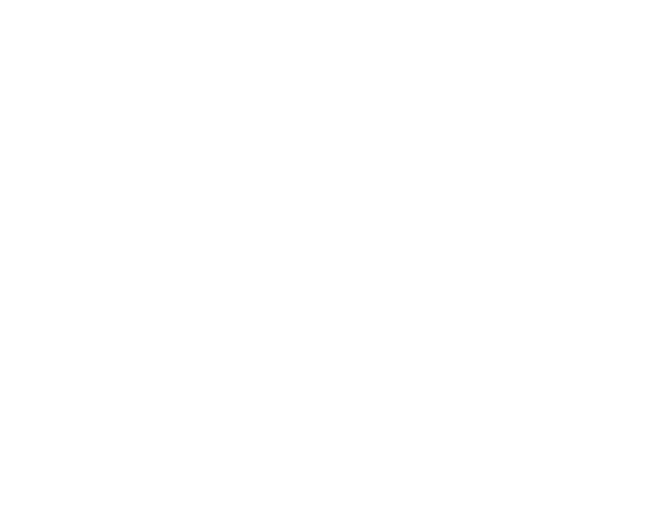

k= (8.574159579495188-0.1122110346719157j)


<IPython.core.display.Javascript object>


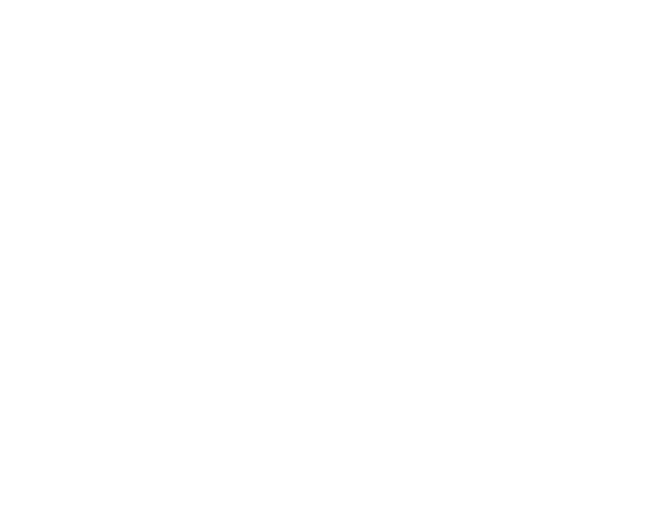

k= (12.401398527837465-0.1132220891540678j)


<IPython.core.display.Javascript object>


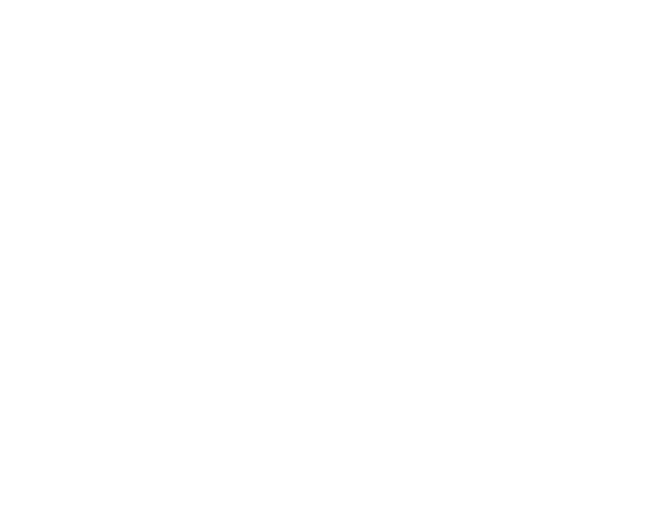

k= (12.072985680480553-0.1642712799465825j)


<IPython.core.display.Javascript object>


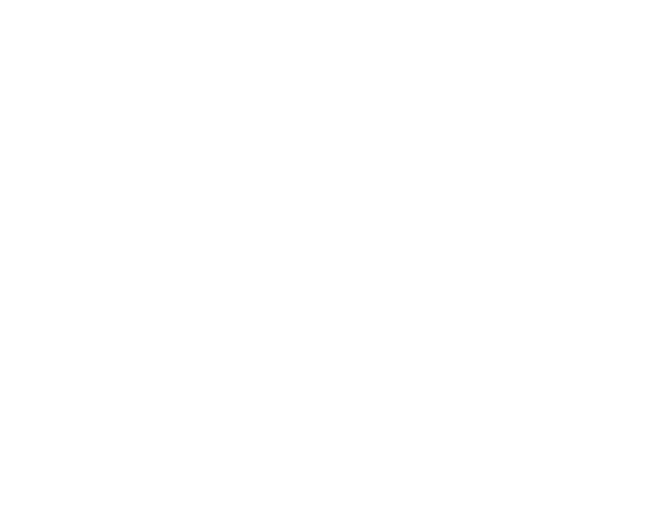

k= (7.0536115303414375-0.17306704460177855j)


<IPython.core.display.Javascript object>


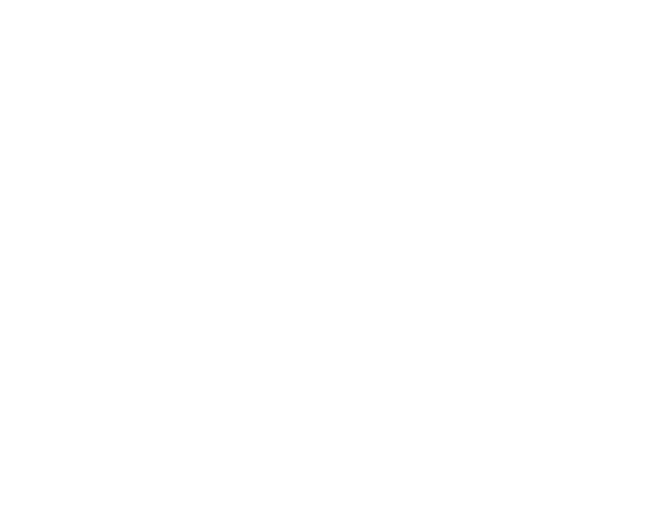

k= (13.182986269276991-0.17924817426168008j)


<IPython.core.display.Javascript object>


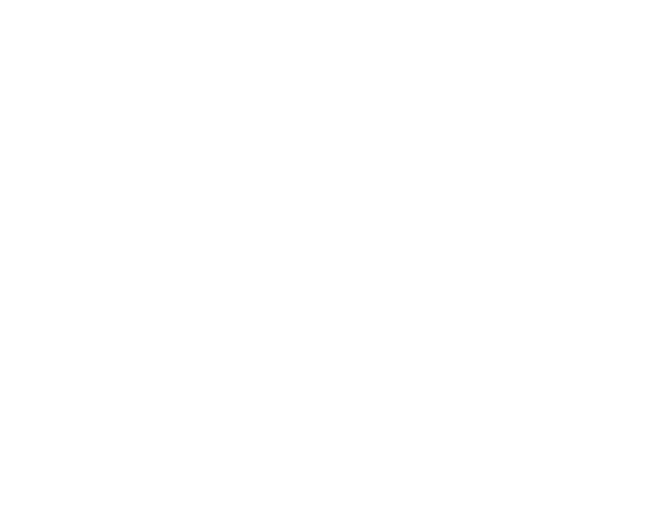

k= (8.242567096283233-0.22358303324414103j)


<IPython.core.display.Javascript object>


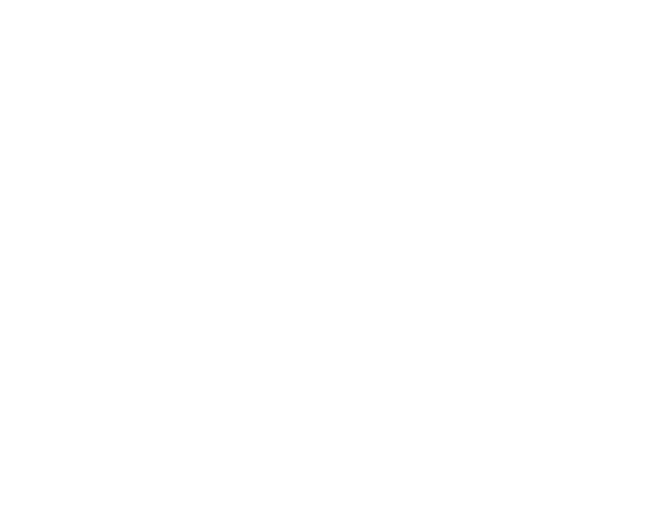

k= (8.92129272144903-0.2385878817809536j)


<IPython.core.display.Javascript object>


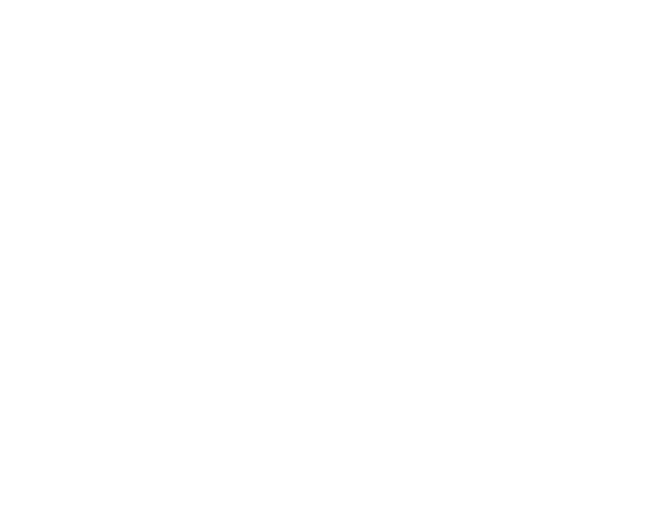

k= (12.956844346201105-0.28297330429384704j)


<IPython.core.display.Javascript object>


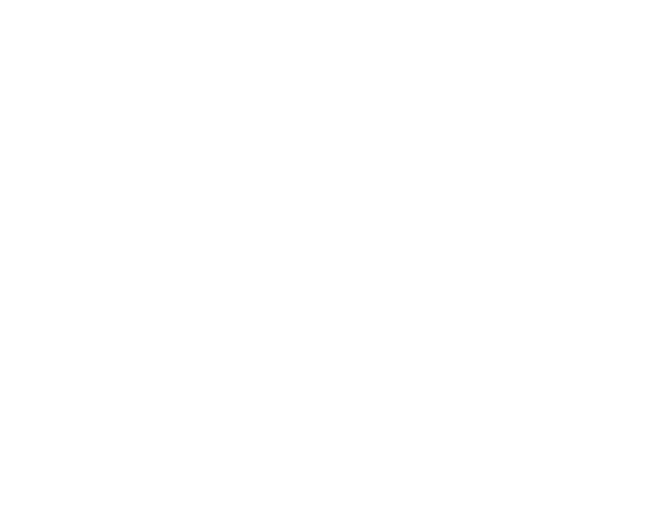

k= (11.293409056356543-0.3142619961325415j)


<IPython.core.display.Javascript object>


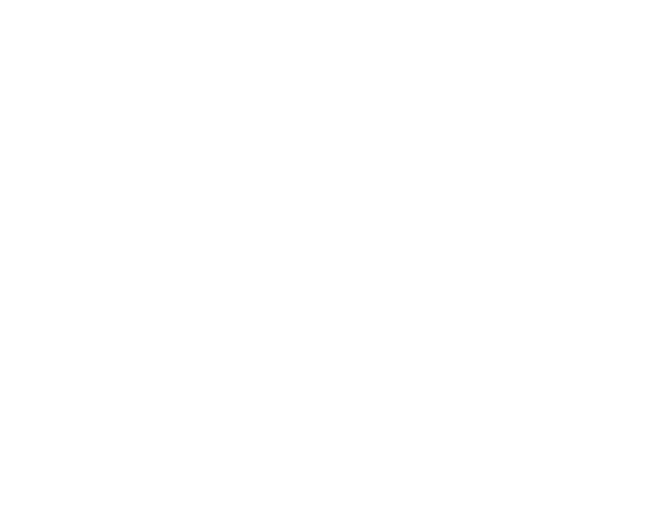

k= (7.210089196562339-0.3315961293298691j)


<IPython.core.display.Javascript object>


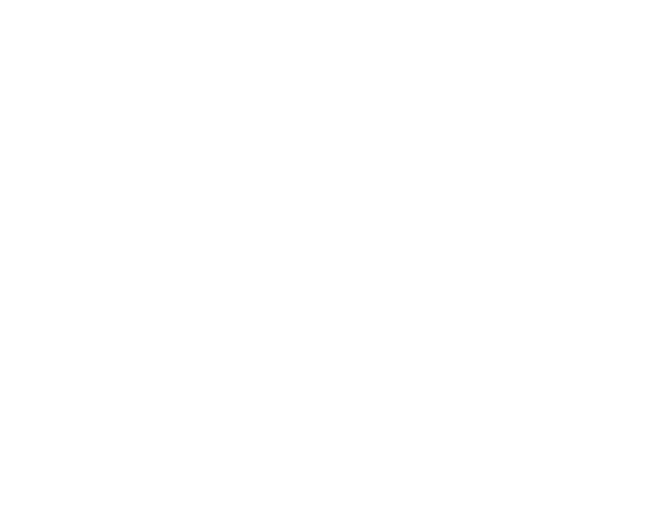

k= (10.097821489674748-0.4183220485328977j)


<IPython.core.display.Javascript object>


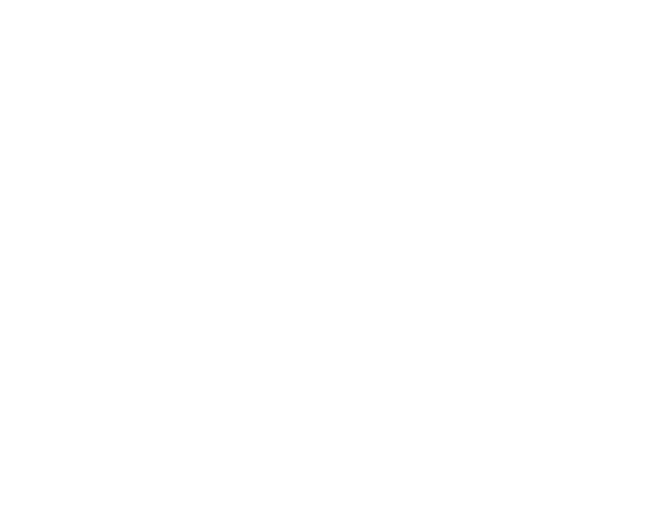

In [10]:
#for each mode, save a figure for it
if not os.path.isdir('pump_modes'):
    os.mkdir('pump_modes')

for m in range(len(modes)):
    print("k=", modes[m,0]-1j*modes[m,1])

    naq_u1.set_chi((modes[m,0]-1j*modes[m,1])*naq_u1.chi0)
    naq_u1.update_laplacian()
    phi = naq_u1.compute_solution()
    edge_color = naq_u1.compute_edge_mean_E2()

    plt.figure(figsize=(5,4))
    
        #find the single lasing edge list (similar to earlier)
    for e in range(len(G.edges)-1):
        #count the number of other modes which can lase
        lasing_count = 0
        for mm in range(len(modes)):
            if mm is not m:
                if pump_th(naq_u1, e+1, modes, D_invs, mm) < D0:
                    lasing_count += 1
                    
        if lasing_count == 0 and pump_th(naq_u1, e+1, modes, D_invs, m) < D0: #if it lasing and no others get the pump

            edge_id = find_list_edges(naq_u1, modes, D_invs, m)[:e+1]

            #get the edge list for the pump
            edge_pump = []
            for k, e in enumerate(G.edges):
                if k in edge_id:
                    edge_pump.append(e)

            edges_pump = nx.draw_networkx_edges(G,pos=pos, edgelist = edge_pump, edge_color = 'r', width=20)
        else:
            break
            
    nodes = nx.draw_networkx_nodes(naq_u1.graph, pos=naq_u1.pos, node_color = 'k', node_size=10)# np.abs(phi)**2, cmap='plasma')
    edges_k = nx.draw_networkx_edges(naq_u1.graph, pos=naq_u1.pos, edge_color = 'k', width=2)

    #plot the edge with large field last (or on top)
    order_edges = np.argsort(edge_color)
    for i in order_edges:
        for ei, e in enumerate(naq_u1.graph.edges):
            if ei == i:
                edges = nx.draw_networkx_edges(naq_u1.graph, pos=naq_u1.pos, edgelist = [e,], edge_color = [edge_color[i],], edge_cmap=plt.get_cmap('Greens'), width=8, alpha=0.7, edge_vmin=0, edge_vmax = np.max(edge_color))
    

    #plt.colorbar(nodes, label=r'Node $|E_i|^2$')
    plt.colorbar(edges, label=r'Edges $\frac{1}{l_{ij}}\int_0^{l_{ij}}|E_{ij}(x)|^2 dx$')

    plt.title("k="+str(np.around(modes[m,0],2)-1j*np.around(modes[m,1],3)))
    plt.axis('off')
    plt.savefig('pump_modes/mode_'+str(m)+'.svg')
    plt.close()

In [30]:
mode_0 = 3
p_len = 1
edge_id = find_list_edges(naq_u1, modes, D_invs, mode_0)

naq_u1.pump_params['edges'] = edge_id[:p_len]  #edges to pump
naq_u1.pump_params['D0'] = D0

#get the approximation of D_th
D0_th = []
for m in range(len(modes)):
    D0_th.append(pump_th(naq_u1, p_len, modes, D_invs, m))
    
D0_steps = 100
D0_max = .15
I = naq_u1.modal_intensities(D0_max, D0_steps, modes, D0_th, linear_approx= True)

100%|██████████| 100/100 [00:02<00:00, 45.86it/s]


<IPython.core.display.Javascript object>


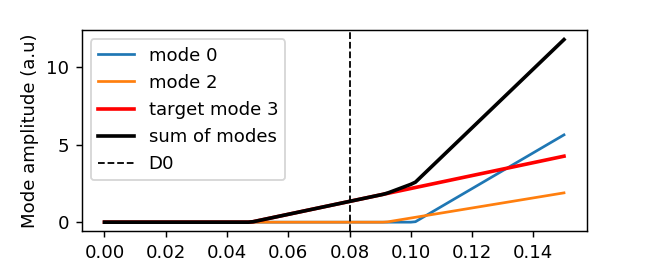

In [31]:
plt.figure(figsize=(5,2))
D0s = np.linspace(0, D0_max, D0_steps)

for i in range(len(I)):
    if I[i].any()>0:
        if i == mode_0:
            plt.plot(D0s, I[i], 'r-',lw=2,  label='target mode '+str(i))

        else:
            plt.plot(D0s, I[i], '-', label='mode '+str(i))
    
plt.plot(D0s, I.sum(0),'-k',lw=2, label='sum of modes')
plt.axvline(D0,c='k',ls='--',lw=1, label='D0')
plt.legend(loc='best')
plt.xlabel('$D_0$')
plt.ylabel('Mode amplitude (a.u)')
plt.savefig('modal_amplitudes.svg', bbox_inches='tight')

100%|██████████| 2/2 [00:00<00:00,  7.44it/s]


<IPython.core.display.Javascript object>


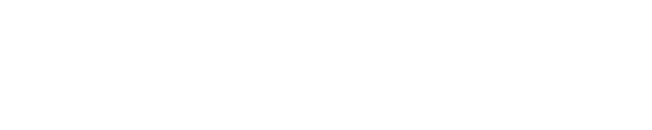

<IPython.core.display.Javascript object>


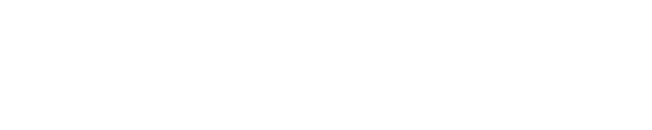

<IPython.core.display.Javascript object>


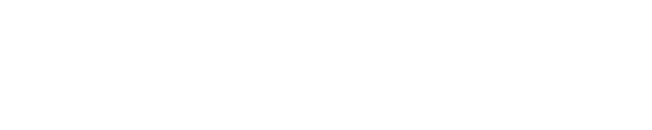

<IPython.core.display.Javascript object>


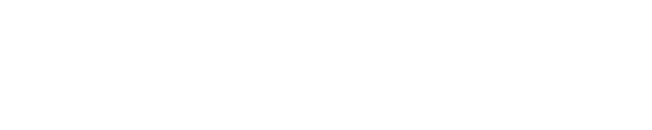

<IPython.core.display.Javascript object>


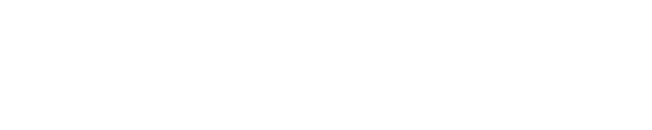

<IPython.core.display.Javascript object>


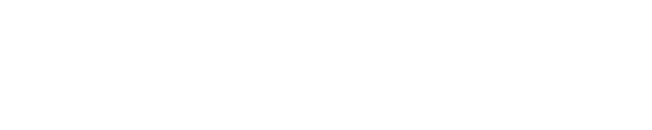

<IPython.core.display.Javascript object>


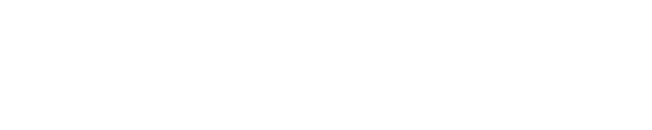

<IPython.core.display.Javascript object>


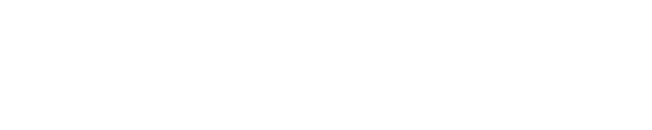

<IPython.core.display.Javascript object>


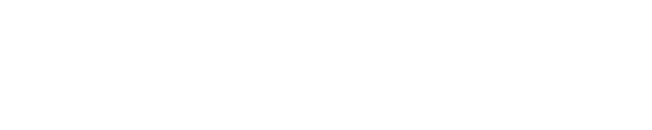

<IPython.core.display.Javascript object>


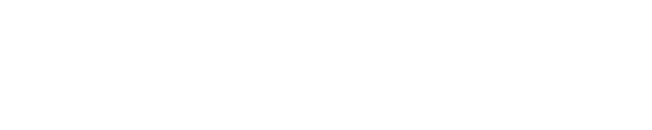

<IPython.core.display.Javascript object>


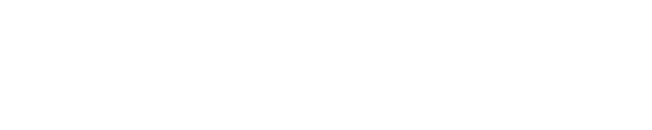

<IPython.core.display.Javascript object>


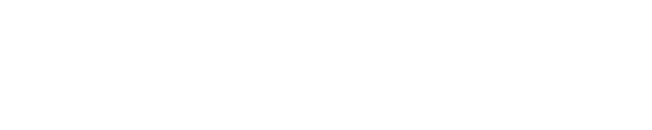

<IPython.core.display.Javascript object>


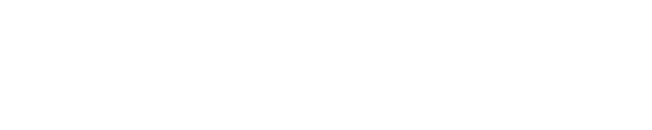

<IPython.core.display.Javascript object>


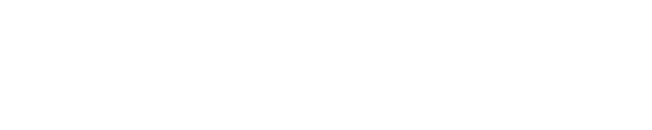

<IPython.core.display.Javascript object>


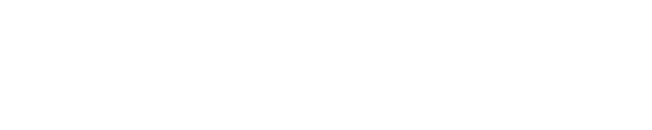

<IPython.core.display.Javascript object>


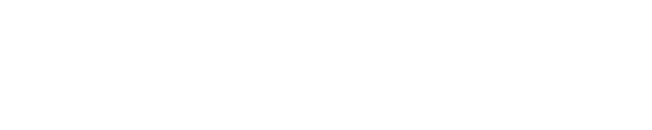

<IPython.core.display.Javascript object>


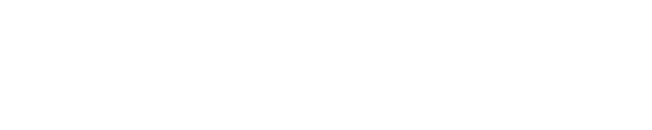

<IPython.core.display.Javascript object>


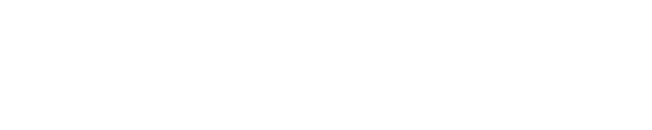

<IPython.core.display.Javascript object>


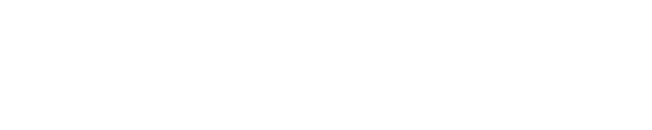

<IPython.core.display.Javascript object>


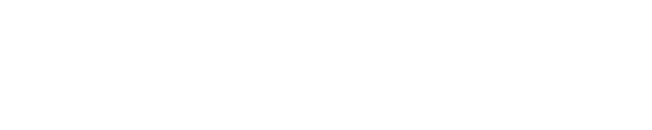

<IPython.core.display.Javascript object>


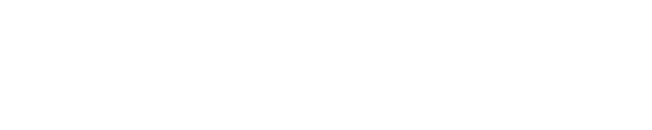

<IPython.core.display.Javascript object>


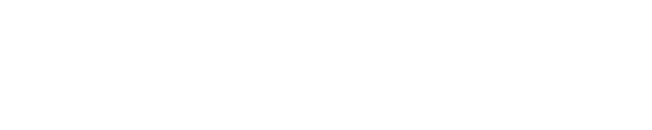

<IPython.core.display.Javascript object>


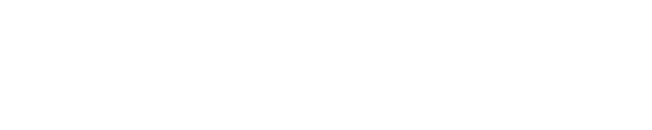

<IPython.core.display.Javascript object>


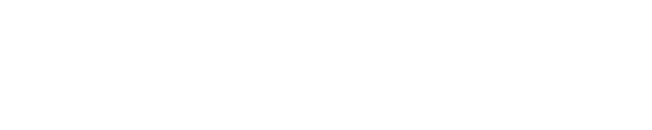

<IPython.core.display.Javascript object>


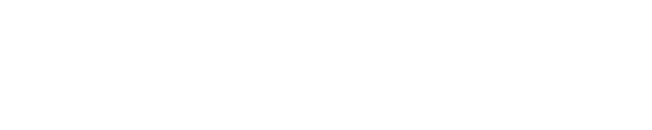

<IPython.core.display.Javascript object>


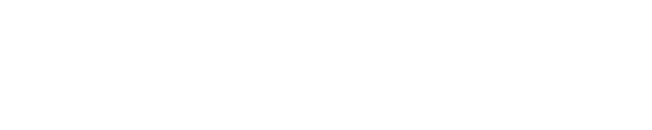

<IPython.core.display.Javascript object>


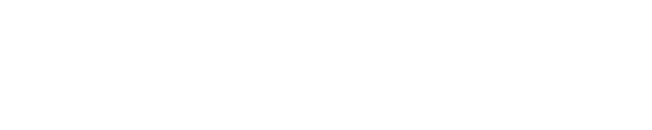

<IPython.core.display.Javascript object>


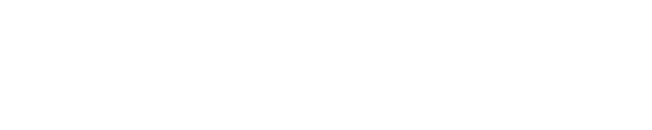

<IPython.core.display.Javascript object>


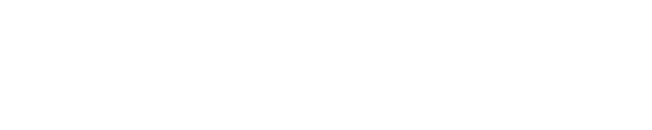

<IPython.core.display.Javascript object>


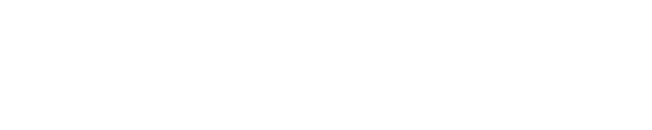

In [34]:
gamma = 0.05

#compute the intermediate amplitudes
D0_steps = 30
I = naq_u1.modal_intensities(D0_max, D0_steps, modes, D0_th, linear_approx= True)

#compute the D0 amplitude
I_D0 = naq_u1.modal_intensities(D0, 2, modes, D0_th, linear_approx= True)[:,-1]

def lorentzian(k, k0, gamma):
    return 1./np.pi * gamma / ( ( k-k0)**2 + gamma**2 ) 

#construct the spectrum for each pump strength
Ks = np.linspace(10,14, 1000)
spectr = np.zeros([np.shape(I)[1], len(Ks)])
for i, m in enumerate(modes):
    for d in range(np.shape(I)[1]):
        spectr[d] += I[i,d]*lorentzian(Ks, m[0], gamma)

if not os.path.isdir('spectra'):
    os.mkdir('spectra')

for d in range(np.shape(I)[1]):

    #plot them 
    plt.figure(figsize=(5,1))
    plt.plot(Ks, spectr[d] , c='k',lw=2)
    plt.axvline(modes[mode_0,0], c='r',lw=0.5)
    plt.xlabel('wavenumber')
    plt.ylabel('spectrum')
    plt.axis([Ks[0],Ks[-1], 0, np.max(I)/np.pi/gamma]) 

    plt.savefig('spectra/spectrum_' +'%0.3d' % d +'.svg', bbox_inches='tight')
    plt.close()